Plot saved to: lineitem_benchmark_results_breakdown.png


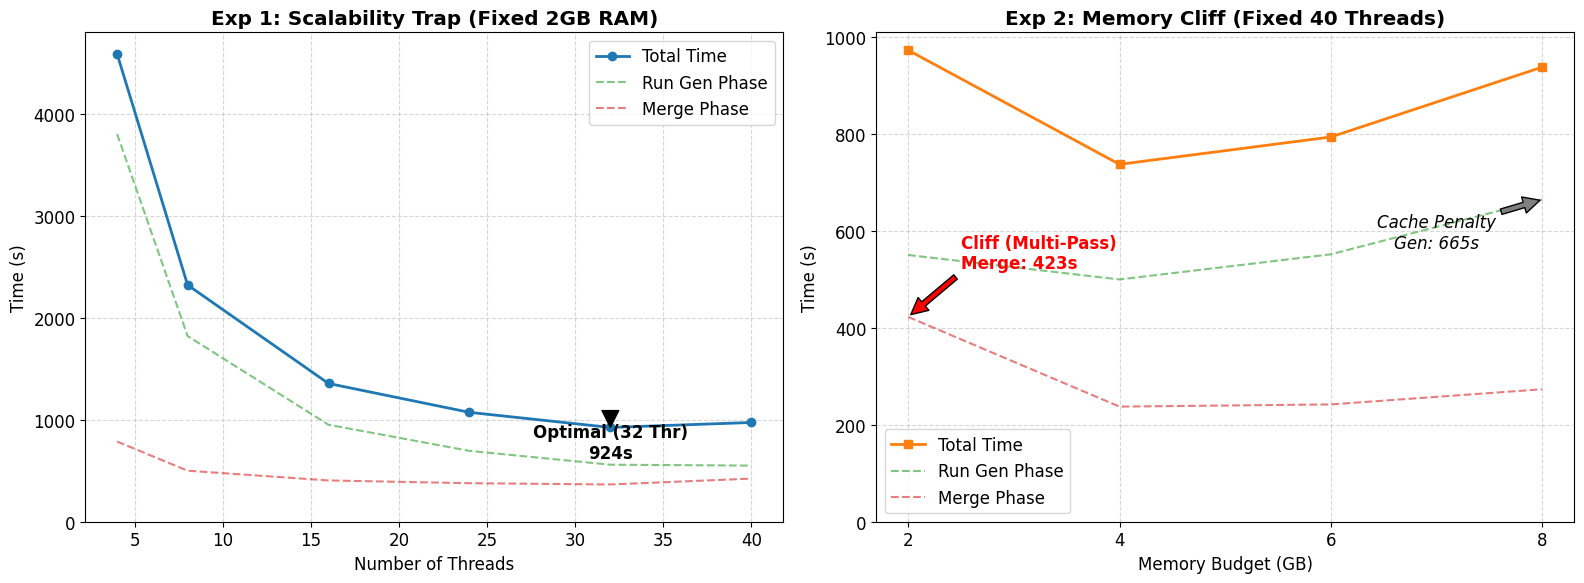

In [4]:
import os
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# CONFIGURATION
# ==========================================
LOG_DIR = '/Users/rikiotaki/workspace/es/logs/lineitem_bench_2025-11-24_23-37-34' 
OUTPUT_PLOT = 'lineitem_benchmark_results_breakdown.png'

# ==========================================
# PARSER LOGIC
# ==========================================
def parse_log_file(filepath):
    filename = os.path.basename(filepath)
    # Parse Metadata (Exp1_Thr8_Mem2GB.log)
    name_match = re.search(r"Thr(\d+)_Mem(\d+)GB", filename)
    if not name_match: return None
    
    threads = int(name_match.group(1))
    memory_gb = int(name_match.group(2))
    
    # Parse Metrics
    metrics = {}
    with open(filepath, 'r') as f:
        for line in f:
            if "[avg]" in line:
                parts = line.split()
                try:
                    metrics['total_time'] = float(parts[5])
                    metrics['rungen_time'] = float(parts[6])
                    metrics['merge_time'] = float(parts[7])
                    break
                except (IndexError, ValueError): continue
                
    if 'total_time' not in metrics: return None
        
    return {
        'filename': filename, 'threads': threads, 'memory_gb': memory_gb,
        'total_time': metrics['total_time'],
        'rungen_time': metrics['rungen_time'],
        'merge_time': metrics['merge_time']
    }

def load_data(directory):
    files = glob.glob(os.path.join(directory, "*.log"))
    data = [parse_log_file(f) for f in files]
    return pd.DataFrame([d for d in data if d])

# ==========================================
# PLOTTING LOGIC
# ==========================================
def plot_results(df):
    if df.empty: return

    plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ---------------------------------------------------------
    # PLOT 1: SCALABILITY TRAP (Fixed 2GB RAM)
    # ---------------------------------------------------------
    exp1_df = df[df['memory_gb'] == 2].sort_values('threads')
    
    if not exp1_df.empty:
        # Total Time
        ax1.plot(exp1_df['threads'], exp1_df['total_time'], 'o-', lw=2, color='#1f77b4', label='Total Time')
        # Components
        ax1.plot(exp1_df['threads'], exp1_df['rungen_time'], '--', color='#2ca02c', alpha=0.6, label='Run Gen Phase')
        ax1.plot(exp1_df['threads'], exp1_df['merge_time'], '--', color='#d62728', alpha=0.6, label='Merge Phase')
        
        # Annotation for Optimal
        opt = exp1_df.loc[exp1_df['total_time'].idxmin()]
        ax1.annotate(f"Optimal ({int(opt['threads'])} Thr)\n{opt['total_time']:.0f}s", 
                     xy=(opt['threads'], opt['total_time']), xytext=(opt['threads'], opt['total_time'] - 300),
                     arrowprops=dict(facecolor='black', shrink=0.05), ha='center', fontweight='bold')

        ax1.set_title("Exp 1: Scalability Trap (Fixed 2GB RAM)", fontweight='bold')
        ax1.set_xlabel("Number of Threads")
        ax1.set_ylabel("Time (s)")
        ax1.grid(True, linestyle='--', alpha=0.5)
        ax1.legend()

        # start from y=0
        ax1.set_ylim(bottom=0)

    # ---------------------------------------------------------
    # PLOT 2: MEMORY CLIFF (Fixed 40 Threads)
    # ---------------------------------------------------------
    exp2_df = df[df['threads'] == 40].sort_values('memory_gb')
    
    if not exp2_df.empty:
        # Total Time
        ax2.plot(exp2_df['memory_gb'], exp2_df['total_time'], 's-', lw=2, color='#ff7f0e', label='Total Time')
        # Components (ADDED THIS)
        ax2.plot(exp2_df['memory_gb'], exp2_df['rungen_time'], '--', color='#2ca02c', alpha=0.6, label='Run Gen Phase')
        ax2.plot(exp2_df['memory_gb'], exp2_df['merge_time'], '--', color='#d62728', alpha=0.6, label='Merge Phase')
        
        # Annotate Cliff
        cliff = exp2_df[exp2_df['memory_gb'] == 2].iloc[0]
        ax2.annotate(f"Cliff (Multi-Pass)\nMerge: {cliff['merge_time']:.0f}s", 
                     xy=(2, cliff['merge_time']), xytext=(2.5, cliff['merge_time'] + 100),
                     arrowprops=dict(facecolor='red', shrink=0.05), color='red', fontweight='bold')

        # Annotate Cache Penalty
        high_mem = exp2_df[exp2_df['memory_gb'] == 8].iloc[0]
        ax2.annotate(f"Cache Penalty\nGen: {high_mem['rungen_time']:.0f}s", 
                     xy=(8, high_mem['rungen_time']), xytext=(7, high_mem['rungen_time'] - 100),
                     arrowprops=dict(facecolor='gray', shrink=0.05), ha='center', style='italic')

        ax2.set_title("Exp 2: Memory Cliff (Fixed 40 Threads)", fontweight='bold')
        ax2.set_xlabel("Memory Budget (GB)")
        ax2.set_ylabel("Time (s)")
        ax2.set_xticks([2, 4, 6, 8])
        ax2.grid(True, linestyle='--', alpha=0.5)
        ax2.legend()

        # start from y=0
        ax2.set_ylim(bottom=0)

    plt.tight_layout()
    plt.savefig(OUTPUT_PLOT, dpi=300)
    print(f"Plot saved to: {OUTPUT_PLOT}")
    plt.show()

df = load_data(LOG_DIR)
plot_results(df)

# Insight

1. The Scalability Trap (Exp 1): Your "Naive" approach was fastest at 24 threads (1090s). When you pushed it to 32 and 40 threads, performance degraded significantly (1545s at 40 threads), proving that "more threads = faster."

2. The Memory Cliff (Exp 2): At 4GB memory, the system ran in 1153s. When dropped to 2GB, it slowed to 1545s (a ~34% penalty) because it fell into Regime 2 (Multi-pass merge).

3. Bonus Insight (CPU Efficiency): Interestingly, the 8GB run (1441s) was slower than the 4GB run (1153s). This likely proves that Replacement Selection is CPU-bound: giant heaps (200MB+) cause more L3 cache misses than medium heaps (100MB), slowing down Run Generation (912s vs 637s). This strengthens your argument for the Planner even more!